# Galton board 

A Galton board is a triangular maze of pins through which balls are fed. At each node, the ball can decide to go left or right. We model this system using a triangular grid of nodes, where each node is a qubit. Each node takes a boolean value, which indicates whether the ball should pass on the left or right, each with 50% probability.

In [46]:
%matplotlib inline

In [47]:
import pylab as pl
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

## Start with unit triangle

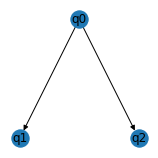

In [48]:
G = nx.DiGraph()
G.add_edges_from([("q0", "q1"), ("q0", "q2")])
pl.figure(figsize=(2,2))
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)

In [49]:
from qiskit import BasicAer
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit.tools.visualization import plot_state_city

In [50]:
# set up Quantum Register and Classical Register for 3 qubits
q = QuantumRegister(3, name="q")
c = ClassicalRegister(3)

In [51]:
qc = QuantumCircuit(q, c)
q0, q1, q2 = q

qc.h(q0)
qc.cx(q0, q1)  # Left branch
qc.x(q0)  # Flip q0 to check for right branch
qc.cx(q0, q2)  # Right branch

qc.barrier()

# flip q0 back
qc.x(q0)

# measure all qubits
qc.barrier()
qc.measure(q, c)

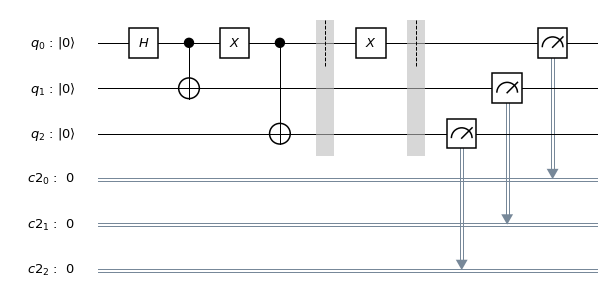

In [52]:
qc.draw(output='mpl')

In [53]:
job = execute(qc, backend=BasicAer.get_backend('qasm_simulator'), shots=10000)
result = job.result()
result.get_counts(qc)

{'011': 4981, '100': 5019}

In [54]:
job = execute(qc, backend=BasicAer.get_backend('statevector_simulator'))
result = job.result()
state = result.get_statevector()

In [55]:
state

array([0.        +0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j,
       0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j])

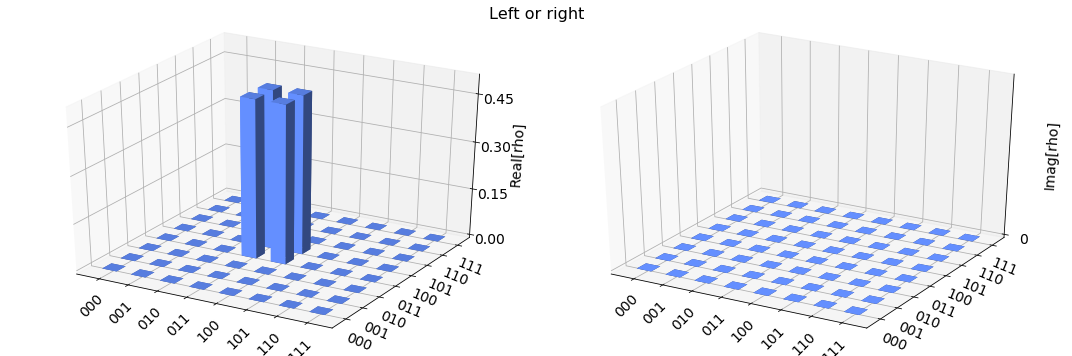

In [56]:
plot_state_city(state, title='Left or right')

In [60]:
sum([s != 0 for s in state])  # Number of possible paths

2

## Scale it up one level

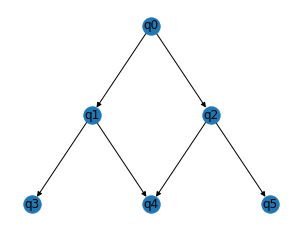

In [61]:
G = nx.DiGraph()
G.add_edges_from([("q0", "q1"), ("q0", "q2"), ("q1", "q3"), ("q1", "q4"), ("q2", "q4"), ("q2", "q5")])
pl.figure(figsize=(4,3))
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)

In [62]:
# set up Quantum Register and Classical Register for 3 qubits
q = QuantumRegister(6, name="q")
c = ClassicalRegister(6)

In [63]:
qc = QuantumCircuit(q)
q0, q1, q2, q3, q4, q5 = q

# First layer. q0 is the control qubit.
qc.h(q0)
qc.cx(q0, q1)
qc.x(q0)
qc.cx(q0, q2)

qc.barrier()

# Second layer: right branch. q0 and q2 are control qubits.
qc.h(q2)
qc.ccx(q0, q2, q4)
qc.x(q2)
qc.ccx(q0, q2, q5)

qc.barrier()

# Second layer: left branch. q0 and q1 are control qubits.
qc.x(q0)   # Flip q0 to use as control
qc.h(q1)
qc.ccx(q0, q1, q3)
qc.x(q1)
qc.ccx(q0, q1, q4)

qc.barrier()

# Flip things back
qc.x(q1)
qc.x(q2)

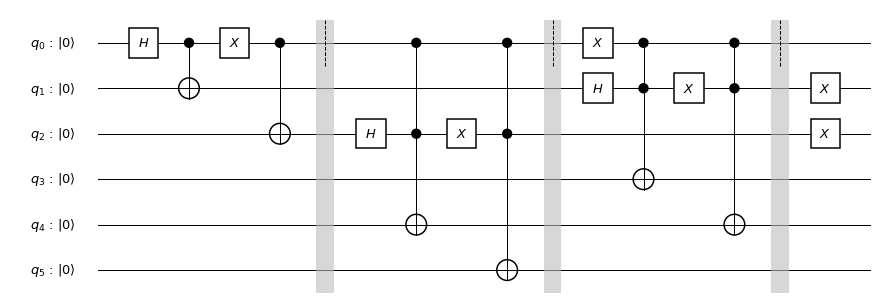

In [64]:
qc.draw(output='mpl')

In [65]:
# Measure all qubits
qc.add_register(c)  # Adding classical register
qc.barrier()
qc.measure(q, c)

In [66]:
job = execute(qc, backend=BasicAer.get_backend('statevector_simulator'))
result = job.result()
state = result.get_statevector()

In [67]:
state

array([ 0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j, -0.35355339+0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j, -0.35355339+0.j,
        0.        +0.j,  0.35355339+0.j,  0.        +0.j,  0.        +0.j,
       -0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.35355339+0.j,  0.        +0.j,  0.35355339+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  

In [68]:
sum([s != 0 for s in state])  # Number of possible paths

8

In [69]:
job = execute(qc, backend=BasicAer.get_backend('qasm_simulator'), shots=10000)
result = job.result()
counts = result.get_counts(qc)
counts

{'010100': 1235,
 '010110': 1257,
 '001011': 1235,
 '100010': 1302,
 '001111': 1260,
 '100000': 1270,
 '010001': 1256,
 '010101': 1185}

In [70]:
# Get mapping from bitstrings to nodes
nodes = [f"{q.name}{n}" for n in range(q.size)]
node_indices = [nodes.index(x) for x in G.nodes() if G.out_degree(x)==0]
bitstrings_to_nodes = {c: [nodes[i] for i in node_indices if list(c)[::-1][i] is "1"][0] for c in counts}

In [71]:
node_indices

[3, 4, 5]

In [72]:
bitstrings_to_nodes

{'010100': 'q4',
 '010110': 'q4',
 '001011': 'q3',
 '100010': 'q5',
 '001111': 'q3',
 '100000': 'q5',
 '010001': 'q4',
 '010101': 'q4'}

In [83]:
node_counts = pd.DataFrame(bitstrings_to_nodes.items(), columns=["bitstring", "node"]
).merge(pd.DataFrame(counts.items(), columns=["bitstring", "count"]))

In [84]:
node_counts

,bitstring,node,count
0,010100,q4,1235
1,010110,q4,1257
2,001011,q3,1235
3,100010,q5,1302
4,001111,q3,1260
5,100000,q5,1270
6,010001,q4,1256
7,010101,q4,1185


In [86]:
count_per_node = node_counts.groupby("node").sum()
count_per_node

,count
node,
q3,2495
q4,4933
q5,2572


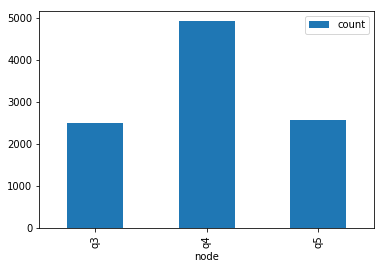

In [87]:
count_per_node.plot(kind="bar")